In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 0: Data Preparation & EDA

## Reading Edges

In [12]:
EDGES_PATH = "dataset/wikivote_subgraph_A_edges.tsv"

edges_A = pd.read_csv(EDGES_PATH, sep="\t")
edges_A.head()

,src,dst
0,0,3
1,0,13
2,0,30
3,0,53
4,0,118


## 0-1: Checking Nodes & Edges

In [13]:
num_edges_A = len(edges_A)
num_nodes_A = int(max(edges_A["src"].max(), edges_A["dst"].max()) + 1)

print(f"Number of nodes: {num_nodes_A}")
print(f"Number of edges: {num_edges_A}")

Number of nodes: 500
Number of edges: 12691


## 0-2: in-degree & out-degree calculation

In [14]:
out_degree_A = np.zeros(num_nodes_A, dtype=np.int64)
in_degree_A = np.zeros(num_nodes_A, dtype=np.int64)

for u, v in edges_A.itertuples(index=False):
    out_degree_A[u] += 1
    in_degree_A[v] += 1


in_stats = {"max": int(np.max(in_degree_A)), "mean": float(np.mean(in_degree_A)), "median": float(np.median(in_degree_A)),
            "zero_percent": float(np.sum(in_degree_A == 0) / len(in_degree_A) * 100)}

out_stats = {"max": int(np.max(out_degree_A)), "mean": float(np.mean(out_degree_A)), "median": float(np.median(out_degree_A)),
            "zero_percent": float(np.sum(out_degree_A == 0) / len(out_degree_A) * 100)}

summary_df = pd.DataFrame.from_dict({"In-degree": in_stats, "Out-degree": out_stats}, orient="index")
summary_df

,max,mean,median,zero_percent
In-degree,95,25.382,22.0,0.0
Out-degree,499,25.382,7.0,25.6


## dangling nodes (out-degree = 0)

In [15]:
dangling_nodes = np.sum(out_degree_A == 0)
dangling_percent = dangling_nodes / num_nodes_A * 100

print(f"Dangling nodes: {dangling_nodes}")
print(f"Dangling percent: {dangling_percent} %")

Dangling nodes: 128
Dangling percent: 25.6 %


## 0-3: Checking Self Loops

In [16]:
num_self_loops = (edges_A["src"] == edges_A["dst"]).sum()
edges_A = edges_A[edges_A["src"] != edges_A["dst"]]

print(f"Number of self-loops removed: {num_self_loops}")

Number of self-loops removed: 0


## 0-4: Nodes based on Top-20

### Top-20 for in-degree

In [17]:
def top_k_nodes(deg, k=20):
    idx = np.argsort(-deg)
    top_list = list(zip(idx[:k], deg[idx[:k]]))

    top_return_list = []
    for node, d in top_list:
        top_return_list.append({'Node':node, 'Degree': d})
    return top_return_list


top20_in_df = pd.DataFrame(top_k_nodes(in_degree_A, 20))
top20_in_df

,Node,Degree
0,121,95
1,168,92
2,448,87
3,322,86
4,132,83
5,338,76
6,13,76
7,88,75
8,176,74
9,155,73


### Top-20 for out-degree

In [18]:
top20_out_df = pd.DataFrame(top_k_nodes(out_degree_A, 20))
top20_out_df

,Node,Degree
0,155,499
1,53,267
2,27,266
3,36,228
4,226,215
5,322,206
6,171,204
7,141,198
8,105,182
9,191,180


## 0-5: Rank-Degree(log-log) plot

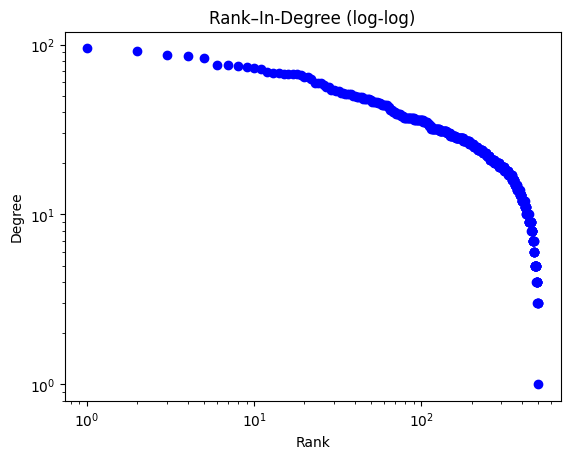

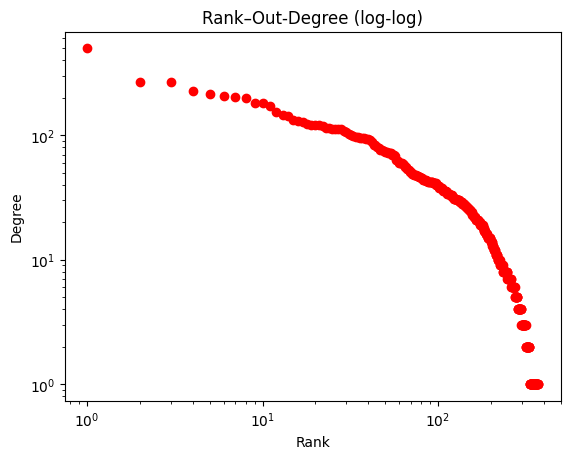

In [19]:
def plot_rank_degree(deg, title, color):
    sorted_deg = np.sort(deg)[::-1]
    ranks = np.arange(1, len(sorted_deg) + 1)

    mask = sorted_deg > 0
    plt.figure()
    plt.loglog(ranks[mask], sorted_deg[mask], marker='o', linestyle='None', color=color)
    plt.xlabel("Rank")
    plt.ylabel("Degree")
    plt.title(title)
    plt.show()

plot_rank_degree(in_degree_A, "Rank–In-Degree (log-log)", 'blue')
plot_rank_degree(out_degree_A, "Rank–Out-Degree (log-log)", 'red')

# Step 1: Dense PageRank on WikiVote Subgraphs

## 1-1: Load edges and Preprocessing of B

In [20]:
EDGES_PATH_B = "dataset/wikivote_subgraph_B_edges.tsv"
EPS = 1e-9
R = 0.15
MAX_ITER = 10_000

edges_B = pd.read_csv(EDGES_PATH_B, sep="\t")
edges_B.head()

,src,dst
0,11,0
1,11,1
2,11,9
3,11,14
4,11,15


In [21]:
num_edges_B = len(edges_B)
num_nodes_B = int(max(edges_B["src"].max(), edges_B["dst"].max()) + 1)

print(f"Number of nodes: {num_nodes_B}")
print(f"Number of edges: {num_edges_B}")

Number of nodes: 500
Number of edges: 14951


In [22]:
out_degree_B = np.zeros(num_nodes_B, dtype=np.int64)
in_degree_B = np.zeros(num_nodes_B, dtype=np.int64)

for u, v in edges_B.itertuples(index=False):
    out_degree_B[u] += 1
    in_degree_B[v] += 1


in_stats_B = {"max": int(np.max(in_degree_B)), "mean": float(np.mean(in_degree_B)), "median": float(np.median(in_degree_B)),
            "zero_percent": float(np.sum(in_degree_B == 0) / len(in_degree_B) * 100)}

out_stats_B = {"max": int(np.max(out_degree_B)), "mean": float(np.mean(out_degree_B)), "median": float(np.median(out_degree_B)),
             "zero_percent": float(np.sum(out_degree_B == 0) / len(out_degree_B) * 100)}

summary_df_B = pd.DataFrame.from_dict({"In-degree": in_stats_B, "Out-degree": out_stats_B}, orient="index")
summary_df_B

,max,mean,median,zero_percent
In-degree,169,29.902,27.5,36.0
Out-degree,178,29.902,23.0,0.0


In [23]:
dangling_nodes_B = np.sum(out_degree_B == 0)
dangling_percent_B = dangling_nodes_B / num_nodes_B * 100

print(f"Dangling nodes: {dangling_nodes_B}")
print(f"Dangling percent: {dangling_percent_B} %")

Dangling nodes: 0
Dangling percent: 0.0 %


In [24]:
num_self_loops_B = (edges_B["src"] == edges_B["dst"]).sum()
edges_B = edges_B[edges_B["src"] != edges_B["dst"]]

print(f"Number of self-loops removed: {num_self_loops_B}")

Number of self-loops removed: 0


## 1-2: Build Adjacency Matrix

In [25]:
n_A = int(max(edges_A["src"].max(), edges_A["dst"].max()) + 1)
m_A = len(edges_A)

A = np.zeros((n_A, n_A), dtype=np.float64)
for u, v in edges_A.itertuples(index=False):
    A[u, v] = 1.0


n_B = int(max(edges_B["src"].max(), edges_B["dst"].max()) + 1)
m_B = len(edges_B)

B = np.zeros((n_B, n_B), dtype=np.float64)
for u, v in edges_B.itertuples(index=False):
    B[u, v] = 1.0

## 1-3: Build Transition Matrix

In [28]:
P_A = np.zeros_like(A)

for i in range(n_A):
    if out_degree_A[i] > 0:
        P_A[i, :] = A[i, :] / out_degree_A[i]


P_B = np.zeros_like(B)

for i in range(n_B):
    if out_degree_B[i] > 0:
        P_B[i, :] = B[i, :] / out_degree_B[i]

In [31]:
P_A[:10, :10]

array([[0.        , 0.        , 0.        , 0.16666667, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.5       , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.03448276, 0.03448276, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01666667, 0.        ,
        0.01666667, 0.        , 0.01666667, 0.01666667, 0.        ],
       [0.        , 0.        , 0.       

In [32]:
P_B[:10, :10]

array([[0.        , 0.01724138, 0.        , 0.01724138, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01724138],
       [0.04      , 0.        , 0.        , 0.04      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04      ],
       [0.        , 0.08333333, 0.        , 0.08333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.08333333],
       [0.06666667, 0.06666667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.06666667],
       [0.00699301, 0.00699301, 0.        , 0.00699301, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00699301],
       [0.        , 0.07142857, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.05882353, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.05882353],
       [0.025     , 0.        , 0.       